In [1]:
using CairoMakie
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets, NonlinearSolve

In [2]:
include("src/parameters.jl")
include("src/filament_state.jl")
∂²γ∂s²(s, δ, α) = (δ / sqrt(π)) * ((2s+1/α)*exp(-(s + 1/(2α))^2) + (2s-1/α)*exp(-(s - 1/(2α))^2))

∂²γ∂s² (generic function with 1 method)

┌ Info: Created simulation parameters
│ Input:
│  Ro=0.8
│  Ri=0.01
│  Ek=0
│  α=1.5
│  λ=0.05
│  δ=-0.25
│  β=0.1
│ Output:
│  L=1
│  f=1
│  H=0.1
│  δH=-0.025
│  N₀=47.677643892862804
│  Nb=1.1356699895745754
│  ℓ=1.5
│  ν=0.0
│  Lz=0.25
│  κ=0.0
└  B₀=0.0
[ Info: Filament state created: Ro=1.8532731708566212, Ro_min=0.7999991463550904, Fr₀=0.038870905093824286, Frb=1.6318765027425455, Ri_min=0.010177366052525266


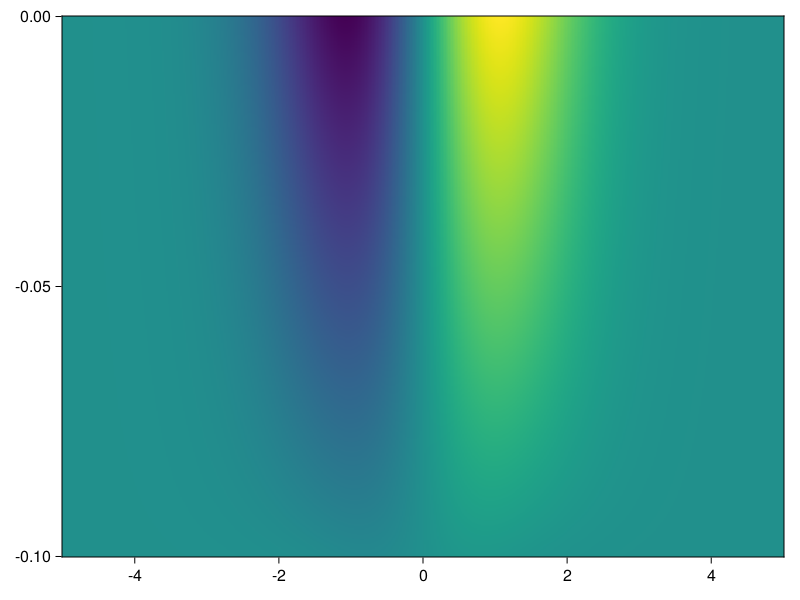

In [3]:
sp = create_simulation_parameters(; Ro=0.8, Ri=0.01, α=1.5)
(b₀, v₀) = get_filament_state(sp)
xs = range(-5sp.L, 5sp.L, 512)
zs = range(-sp.H, 0, 512)
heatmap(xs, zs, v₀)

In [17]:
# non-dimensional parameters
ss = xs / sp.ℓ
rs = zs / sp.H
A = 10
a(s, r) = A*(∂γ∂s(s, sp.δ, sp.α)^2 - (r - γ(s, sp.δ, sp.α)) * ∂²γ∂s²(s, sp.δ, sp.α))
b(s) = 2A * ∂γ∂s(s, sp.δ, sp.α)

b (generic function with 1 method)

In [18]:
@parameters r s t
@variables ψ(..), ψ_rr(..)
Dr = Differential(r)
Ds = Differential(s)
Dt = Differential(t)
Drr = Differential(r)^2
Dss = Differential(s)^2
Dtt = Differential(t)^2
Dsr = Differential(s) * Differential(r)
eq  = [
    Dtt(ψ_rr(r, s, t)) + Dt(ψ_rr(r, s, t))/30 ~ -ψ_rr(r, s, t) + a(s, r) * ψ_rr(r, s, t) + b(s) * Dsr(ψ(r, s, t)),
    ψ_rr(r, s, t) ~ Drr(ψ(r, s, t))
]
domains = [
    r ∈ Interval(-1.0, 0.0),
    s ∈ Interval(-1.5, 1.5),
    t ∈ Interval(0.0, 10.0),
]
bcs = [
    ψ(r, -1.5, t) ~ ψ(r, 1.5, t),
    ψ_rr(r, -1.5, t) ~ ψ_rr(r, 1.5, t),
    ψ(0.0, s, t) ~ 0,
    ψ(-1.0, s, t) ~ 0,
    ψ_rr(-1.0, s, t) ~ Drr(ψ(-1.0, s, t)),
    ψ_rr(0.0, s, t) ~ Drr(ψ(0.0, s, t)),
    ψ(r, s, 0.0) ~ 0,
    ψ_rr(r, s, 0.0) ~ 0,
    Dt(ψ(r, s, 0.0)) ~ r * (r+1.0) * (r+0.5) * ∂γ∂s(s, sp.δ, sp.α) / 10,
    Dt(ψ_rr(r, s, 0.0)) ~  3 * (2r+1) * ∂γ∂s(s, sp.δ, sp.α) / 10
]

@named pdesys = PDESystem(eq, bcs, domains, [r, s, t], [ψ(r, s, t), ψ_rr(r, s, t)])

PDESystem
Equations: Equation[Differential(t)(Differential(t)(ψ_rr(r, s, t))) + (1//30)*Differential(t)(ψ_rr(r, s, t)) ~ -ψ_rr(r, s, t) - 2.8209479177387813(exp(-((0.3333333333333333 + s)^2)) - exp(-((-0.3333333333333333 + s)^2)))*Differential(s)(Differential(r)(ψ(r, s, t))) + 10(0.019894367886486915((exp(-((0.3333333333333333 + s)^2)) - exp(-((-0.3333333333333333 + s)^2)))^2) + 0.14104739588693907(1 + r + 0.125(-SpecialFunctions.erf(-0.3333333333333333 + s) + SpecialFunctions.erf(0.3333333333333333 + s)))*((0.6666666666666666 + 2s)*exp(-((0.3333333333333333 + s)^2)) + (-0.6666666666666666 + 2s)*exp(-((-0.3333333333333333 + s)^2))))*ψ_rr(r, s, t), ψ_rr(r, s, t) ~ Differential(r)(Differential(r)(ψ(r, s, t)))]
Boundary Conditions: Equation[ψ(r, -1.5, t) ~ ψ(r, 1.5, t), ψ_rr(r, -1.5, t) ~ ψ_rr(r, 1.5, t), ψ(0.0, s, t) ~ 0, ψ(-1.0, s, t) ~ 0, ψ_rr(-1.0, s, t) ~ Differential(r)(Differential(r)(ψ(-1.0, s, t))), ψ_rr(0.0, s, t) ~ Differential(r)(Differential(r)(ψ(0.0, s, t))), ψ(r, s, 0.0) ~ 

In [19]:
N=20
discretization = MOLFiniteDifference([s=>N, r=>N], t, approx_order=2)
prob = discretize(pdesys, discretization)

┌ Warning: The system contains interface boundaries, which are not compatible with system transformation. The system will not be transformed. Please post an issue if you need this feature.
└ @ MethodOfLines ~/.julia/packages/MethodOfLines/qu7lv/src/system_parsing/pde_system_transformation.jl:42


ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 703-element Vector{Float64}:
 -0.0
  0.01139867804435449
 -0.0
  0.010057657097959844
 -0.0
  0.008716636151565198
 -0.0
  0.007375615205170553
 -0.0
  0.006034594258775906
 -0.0
  0.004693573312381261
 -0.0
  ⋮
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0

In [20]:
# Solve ODE problem
using OrdinaryDiffEq
sol = solve(prob, QNDF(), saveat=0.1)

LoadError: mul_float: types of a and b must match

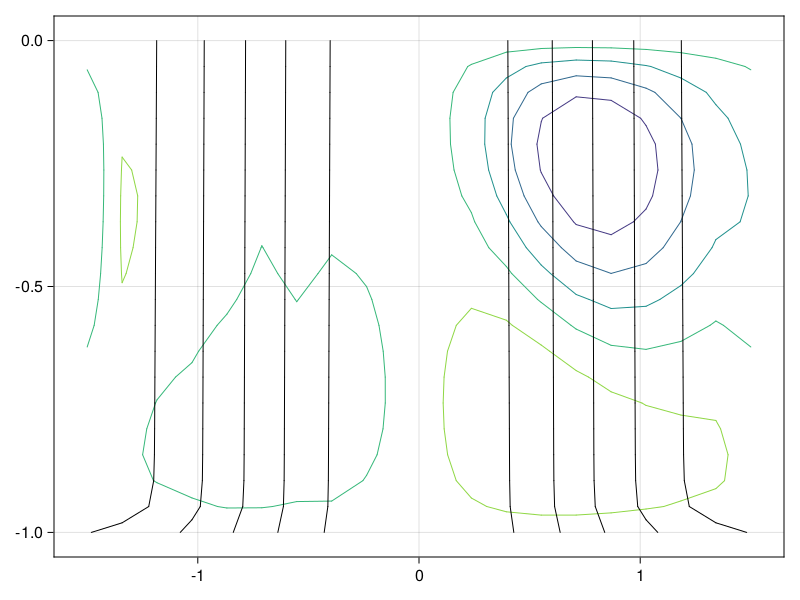

In [21]:
fig = Figure()
ax = Axis(fig[1, 1])
contour!(ax, sol[s], sol[r], transpose(sol.u[ψ(r, s, t)][:, :, 10]))
contour!(ax, sol[s], sol[r], (s, r)->b₀(sp.ℓ*s, sp.H*r), color=:black)
fig

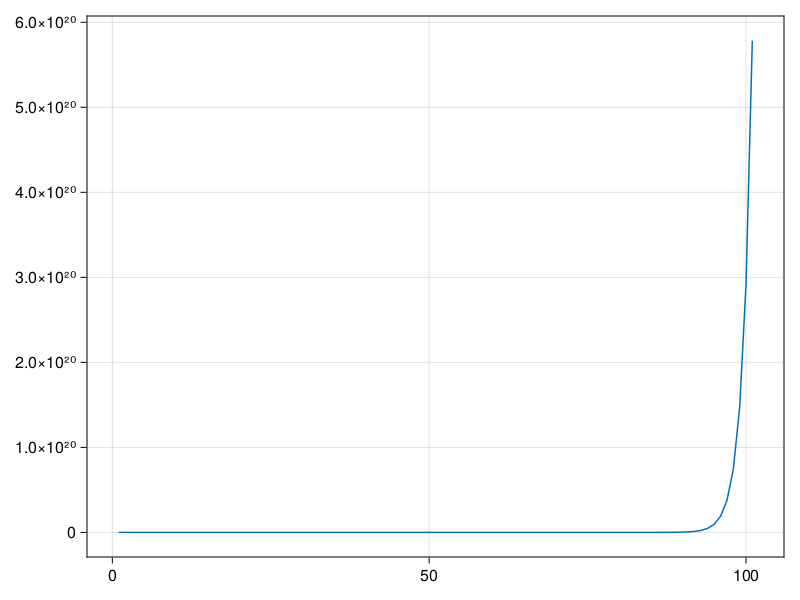

In [10]:
lines(sum(sol.u[ψ(r, s, t)].^2; dims=(1, 2))[1, 1, :])